# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## MNIST Dataset


9913344it [00:00, 48425828.29it/s]                             


Extracting ./MNIST_data\MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST_data\MNIST\raw



29696it [00:00, 28508595.01it/s]         


Extracting ./MNIST_data\MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST_data\MNIST\raw



1649664it [00:00, 39161175.62it/s]         


Extracting ./MNIST_data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST_data\MNIST\raw



5120it [00:00, 5135063.72it/s]          


Extracting ./MNIST_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST_data\MNIST\raw



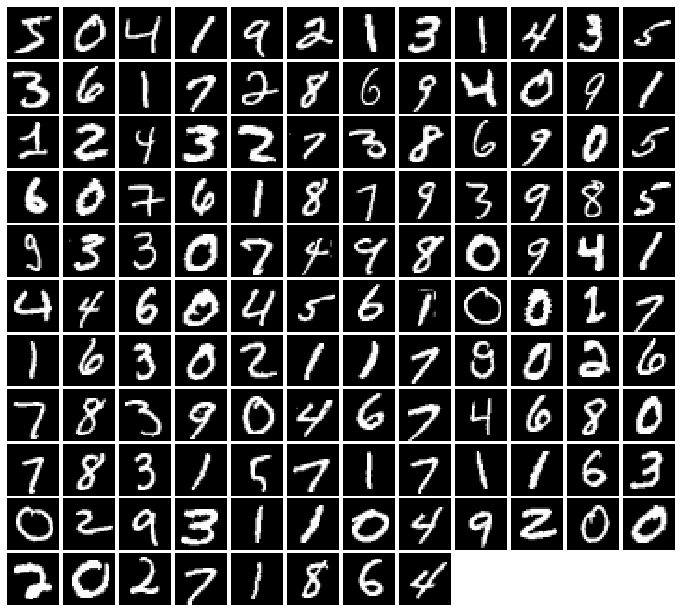

In [5]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [7]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [8]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential(
        Flatten(),
        torch.nn.Linear(784, 256), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(256, 256), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(256, 1)
    )
    return model

In [9]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="gan_samples/mnist.jpg" width=500>

In [17]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1


In [ ]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)